In [1]:
print ('hello')

hello


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


In [3]:


# Load the dataset (ensure the path is correct)
data = pd.read_csv('data.csv')

# Display basic information about the dataset
print("Dataset Info:")
data.info()

# Show first few rows
print("First few rows of data:")
data.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
First few rows of data:


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [22]:
# Handle missing values separately for numeric and categorical columns
# Fill missing values for numeric columns with the median
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# For categorical columns, fill missing values with the mode (most frequent value)
categorical_columns = data.select_dtypes(include=[object]).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Show if there are still any missing values
print("Missing values after imputation:")
print(data.isnull().sum())




Missing values after imputation:
ID       0
M/F      0
Hand     0
Age      0
Educ     0
SES      0
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
Delay    0
dtype: int64


In [24]:
# Feature selection (Ensure X contains only numeric features)
X = data.select_dtypes(include=[np.number]).drop(columns=['MMSE'])  # Exclude MMSE as target

y = data['MMSE']  # Target variable is MMSE

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (only numeric columns)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check if scaling was successful by printing out the shape
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")


Shape of X_train_scaled: (348, 8)
Shape of X_test_scaled: (88, 8)


In [25]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR()
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'R^2': r2
    }

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results).T
print("Model Comparison Results:")
print(results_df)


Model Comparison Results:
                                  MAE       MSE       R^2
Linear Regression            0.808064  1.784331  0.714297
Random Forest Regressor      0.870866  3.191533  0.488978
Gradient Boosting Regressor  0.934130  3.109380  0.502132
Support Vector Regressor     0.876005  2.999871  0.519667


In [26]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)
best_rf = grid_search_rf.best_estimator_

# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3, n_jobs=-1)
grid_search_gb.fit(X_train_scaled, y_train)
best_gb = grid_search_gb.best_estimator_


In [27]:
# Evaluate the tuned models
tuned_models = {
    "Best Random Forest": best_rf,
    "Best Gradient Boosting": best_gb
}

# Store results for tuned models
tuned_results = {}
for model_name, model in tuned_models.items():
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    tuned_results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'R^2': r2
    }

tuned_results_df = pd.DataFrame(tuned_results).T
print("Tuned Model Comparison Results:")
print(tuned_results_df)


Tuned Model Comparison Results:
                             MAE       MSE       R^2
Best Random Forest      0.802534  2.511529  0.597859
Best Gradient Boosting  0.851077  2.751956  0.559362


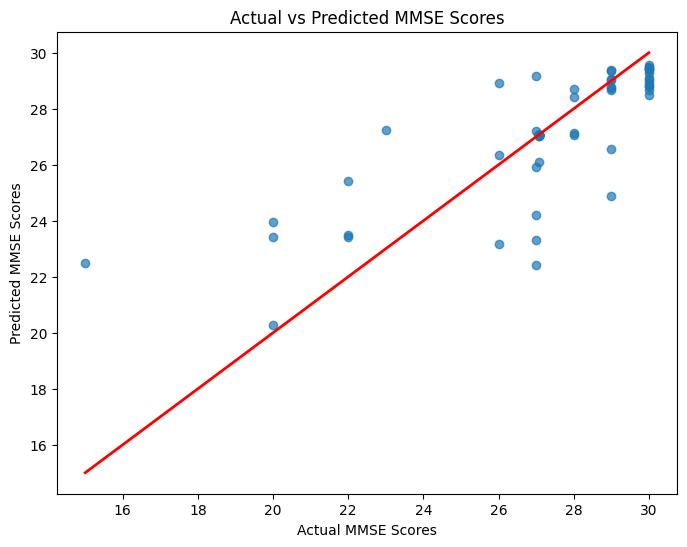

Final Model - MAE: 0.8025337636122573
Final Model - MSE: 2.511528977792073
Final Model - R^2: 0.597859030031135


In [28]:
# Choose the best model based on evaluation metrics and visualize the results
best_model = best_rf  # Change to the best-performing model after comparison
y_pred_final = best_model.predict(X_test_scaled)

# Visualize Actual vs Predicted MMSE Scores for the best model
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_final, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual MMSE Scores')
plt.ylabel('Predicted MMSE Scores')
plt.title('Actual vs Predicted MMSE Scores')
plt.show()

# Calculate final performance metrics
mae_final = mean_absolute_error(y_test, y_pred_final)
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Final Model - MAE: {mae_final}")
print(f"Final Model - MSE: {mse_final}")
print(f"Final Model - R^2: {r2_final}")
